<a href="https://colab.research.google.com/github/JoaoAlexandreFerreira/RNA/blob/main/Burgers_Tensorflow_PINN_Jo%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
pip install --upgrade pyDOE

In [28]:
import tensorflow as tf
from scipy.io import loadmat
import numpy as np
import keras
import matplotlib.pyplot as plt
import pandas as pd
from keras import Sequential
from keras.layers import Input, Dense
from time import time
from keras.optimizers import Adam
from keras.initializers import Ones, GlorotNormal, he_normal, Zeros
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from pyDOE import lhs
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.optimize

In [29]:
keras.backend.set_floatx('float32')
tf.random.set_seed(0)
pi = tf.constant(np.pi)
mi = 0.01/tf.constant(np.pi)
dados = loadmat('burgers_shock.mat')
x_dados = dados['x'].flatten()[:,None]
u_dados = np.real(dados['usol']).T

#Definindo as condições de contorno e inicial
def inicial(x):
  return -tf.sin(pi*x)

def contorno(t, x):
  n = x.shape[0]
  return tf.zeros((n,1))

#Definindo os pontos X
N_0 = 100 #100 pontos para condição inicial
N_b = 100 #100 pontos para condição de contorno
N_r = 10000 #Pontos para a edp

#Pontos do domínio, dado pelo Maziar
tmin = 0. ; tmax = 1.
xmin = -1.; xmax = 1.

#Ponto inferior e superior, respectivamente
lb = tf.constant([tmin, xmin]); ub = tf.constant([tmax, xmax])

#Obtendo pontos para a condição inicial
t0 = tf.zeros((N_0,1))*lb[0]
x0 = tf.random.uniform((N_0,1), lb[1], ub[1]) #Colocando os valores de x0 em ordem aleatoria, indo de -1 a 1
x0 = tf.concat([t0, x0], 1) #Criando uma matriz com os valores de tempo = 0 e de x0

#Valores de u para a condição inicial
u_ini = inicial(x0[:,1:2])

#Repetindo o processo, mas para a condição de contorno
tb = tf.random.uniform((N_b,1), lb[0], ub[0])
xb = lb[1] + (ub[1] - lb[1]) * keras.backend.random_bernoulli((N_b,1), 0.5)
xb = tf.concat([tb, xb], 1)

#Valores na condição de contorno
u_cont = contorno(xb[:,0:1], xb[:,1:2])

#Repetindo o processo, mas agora é para obter os pontos da EDP
tr = tf.random.uniform((N_r,1), lb[0], ub[0])
xr = tf.random.uniform((N_r,1), lb[1], ub[1])
xr = tf.concat([tr, xr], 1)

#Fazendo uma lista, para uso posterior
X_cond = [x0, xb]
u_cond = [u_ini, u_cont]

#Realizando plotagem dos pontos que são usados para condição de contorno, inicial e para edp

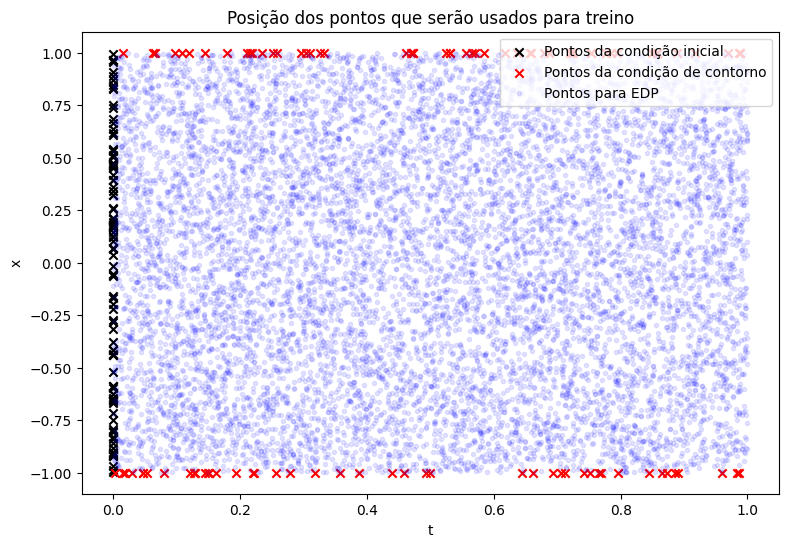

In [30]:
plt.figure(figsize=(9,6))
plt.scatter(x0[:,0:1],x0[:,1:2], c='black', marker ='x')
plt.scatter(xb[:,0:1],xb[:,1:2], c='red', marker ='x')
plt.scatter(xr[:,0:1], xr[:,1:2], c='blue', marker = '.', alpha = 0.1)
plt.xlabel('t'); plt.ylabel('x')
plt.title('Posição dos pontos que serão usados para treino')
plt.legend(['Pontos da condição inicial', 'Pontos da condição de contorno', 'Pontos para EDP'])
plt.show()

In [31]:
#Agora criando o modelo de Rede neural

def modelopinn(nos, camadas_ocultas):
  modelo = Sequential()
  #Inserindo o numero de variaveis de entrada
  modelo.add(Input(2))

  modelo.add(keras.layers.Lambda(
      lambda x: 2.0*(x - lb)/(ub - lb) - 1.0
  ))
  for i in range(camadas_ocultas):
        modelo.add(Dense(nos, activation='tanh', kernel_initializer=GlorotNormal()))

  modelo.add(Dense(1))
  modelo.summary()
  return modelo

In [32]:
#E tirando os gradientes, para calcular a edp
def gradiente(modelo, X_r):
  with tf.GradientTape(persistent=True) as tape:
    t, x = X_r[:, 0:1], X_r[:,1:2]
    tape.watch(t)
    tape.watch(x)
    u = modelo(tf.stack([t[:,0], x[:,0]], 1))

    ux = tape.gradient(u, x)

    ut = tape.gradient(u, t)
    uxx = tape.gradient(ux, x)

  del tape

  return ut + u*ux - mi*uxx

def MSE(modelo, xr, X_cond, u_cond):

    #Erro edp
    r = gradiente(modelo, xr)
    erro = tf.reduce_mean(tf.square(r))

    loss = erro

    #Erro da rede neural
    for i in range(len(X_cond)):
        u_pred = modelo(X_cond[i])
        loss += tf.reduce_mean(tf.square(u_cond[i] - u_pred))

    return erro, loss

def grad(modelo, xr, X_cond, u_cond):
  with tf.GradientTape(persistent=True) as tape:
    tape.watch(modelo.trainable_variables)
    erro, loss = MSE(modelo, xr, X_cond, u_cond)

  g = tape.gradient(loss, modelo.trainable_variables)
  del tape

  return erro, loss, g

In [33]:
modelo = modelopinn(20,8)

otimizador = Adam(learning_rate = 0.001)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_5 (Lambda)           (None, 2)                 0         
                                                                 
 dense_36 (Dense)            (None, 20)                60        
                                                                 
 dense_37 (Dense)            (None, 20)                420       
                                                                 
 dense_38 (Dense)            (None, 20)                420       
                                                                 
 dense_39 (Dense)            (None, 20)                420       
                                                                 
 dense_40 (Dense)            (None, 20)                420       
                                                                 
 dense_41 (Dense)            (None, 20)               

In [34]:
@tf.function
def train_step(modelo):
  erro, loss, grad_theta = grad(modelo, xr, X_cond, u_cond)

  otimizador.apply_gradients(zip(grad_theta, modelo.trainable_variables))

  return erro, loss

itr = 5000
historico = []
erro_aux = []
t0 = time()

for i in range(itr+1):

    erro, loss = train_step(modelo)

    #Salvando os erros para listar
    historico.append(loss.numpy())
    erro_aux.append(erro.numpy)

    if i%10 == 0:
        print(i,"Loss treino: {:10.8e}, Loss edp: {:10.8e}".format(loss, erro))

print('\nTempo de treino da rede neural: {} segundos'.format(time()-t0))

0 Loss treino: 9.78806674e-01, Loss edp: 3.65471244e-01
10 Loss treino: 4.71130937e-01, Loss edp: 2.81654727e-02
20 Loss treino: 4.10254866e-01, Loss edp: 6.14374969e-03
30 Loss treino: 3.94300014e-01, Loss edp: 7.47849885e-03
40 Loss treino: 3.77494991e-01, Loss edp: 9.20349080e-03
50 Loss treino: 3.63136828e-01, Loss edp: 1.63521264e-02
60 Loss treino: 3.45961869e-01, Loss edp: 2.48458777e-02
70 Loss treino: 3.20268512e-01, Loss edp: 3.10736261e-02
80 Loss treino: 2.83071876e-01, Loss edp: 3.57649587e-02
90 Loss treino: 2.39076227e-01, Loss edp: 4.28627506e-02
100 Loss treino: 2.04809949e-01, Loss edp: 5.54504469e-02
110 Loss treino: 1.87688857e-01, Loss edp: 6.81119114e-02
120 Loss treino: 1.76045433e-01, Loss edp: 6.89063519e-02
130 Loss treino: 1.68566495e-01, Loss edp: 6.22047484e-02
140 Loss treino: 1.63172066e-01, Loss edp: 5.79592884e-02
150 Loss treino: 1.58990502e-01, Loss edp: 5.80485463e-02
160 Loss treino: 1.55414298e-01, Loss edp: 5.68997785e-02
170 Loss treino: 1.522268

In [35]:
N = 600
tspace = np.linspace(lb[0], ub[0], N + 1)
xspace = np.linspace(lb[1], ub[1], N + 1)
T, X = np.meshgrid(tspace, xspace)
Xgrid = np.vstack([T.flatten(),X.flatten()]).T

#Realizando predição
upred = modelo(Xgrid)

U = upred.numpy().reshape(N+1,N+1)

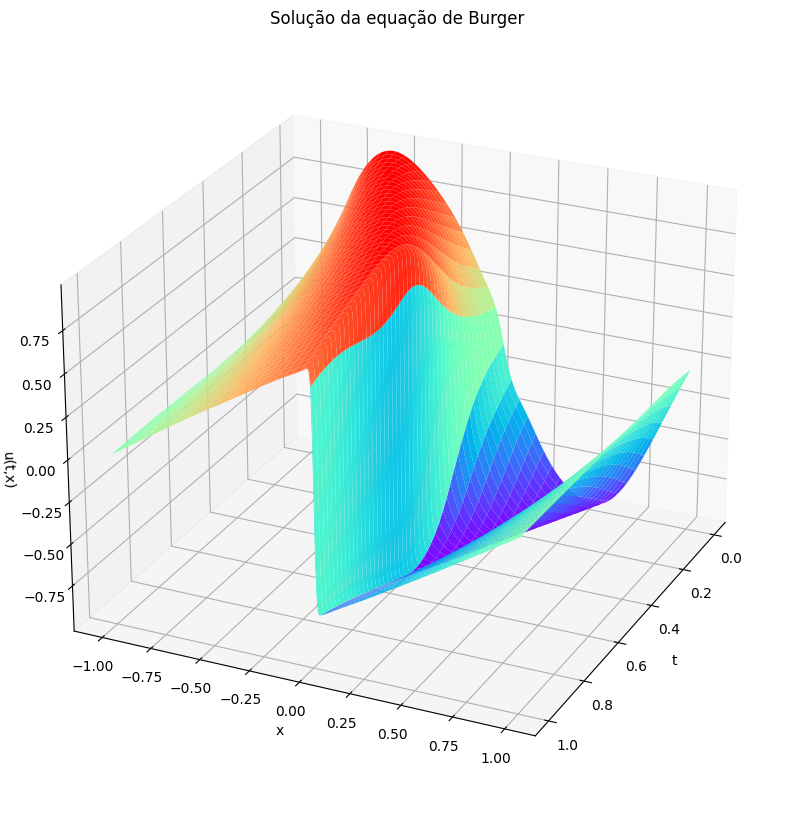

In [36]:
fig = plt.figure(figsize=(10,12))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(T, X, U, cmap='rainbow');
ax.view_init(25,25)
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.set_zlabel('u(t,x)')
ax.set_title('Solução da equação de Burger');
plt.show()

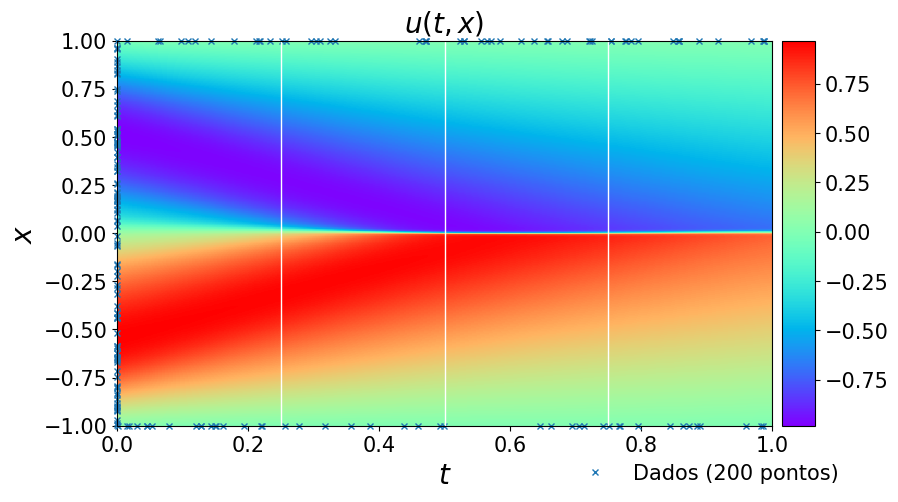

In [37]:
X_aux = np.vstack([x0,xb])
u_aux = np.vstack([u_ini,u_cont])
fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)

h = ax.imshow(U, interpolation='nearest', cmap='rainbow',
              extent=[tmin, tmax, xmin, xmax],
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15)

ax.plot(
    X_aux[:,0],
    X_aux[:,1],
    'x', label = 'Dados (%d pontos)' % (u_aux.shape[0]),
    markersize = 4,
    clip_on = False,
    alpha=1.0
)

line = np.linspace(xmin, xmax, 2)[:,None]
ax.plot(tspace[150]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(tspace[300]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(tspace[450]*np.ones((2,1)), line, 'w-', linewidth = 1)

ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
ax.legend(
    loc='upper center',
    bbox_to_anchor=(0.9, -0.05),
    ncol=5,
    frameon=False,
    prop={'size': 15}
)
ax.set_title('$u(t,x)$', fontsize = 20)
ax.tick_params(labelsize=15)

plt.show()

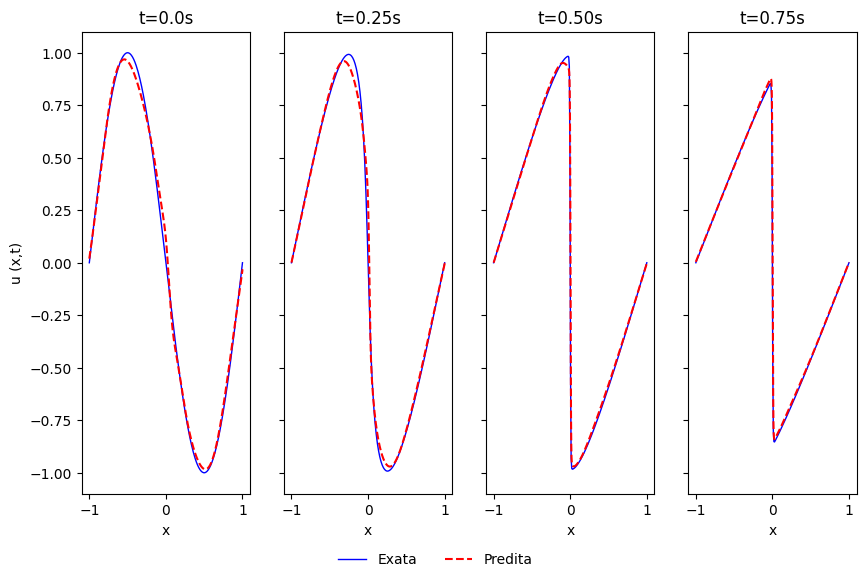

In [38]:
N = 600
xspace = np.linspace(lb[1], ub[1], N + 1)

t_ini = np.zeros((N+1))
T, X = np.meshgrid(t_ini, xspace)
X0 = np.vstack([T.flatten(),X.flatten()]).T

t_025 = np.ones((N+1))*0.25
T, X = np.meshgrid(t_025, xspace)
X025 = np.vstack([T.flatten(),X.flatten()]).T

t_050 = np.ones((N+1))*0.50
T, X = np.meshgrid(t_050, xspace)
X050 = np.vstack([T.flatten(),X.flatten()]).T

t_075 = np.ones((N+1))*0.75
T, X = np.meshgrid(t_075, xspace)
X075 = np.vstack([T.flatten(),X.flatten()]).T

fig, axs = plt.subplots(1, 4, figsize=(10,6) ,sharey=True)

axs[0].plot(x_dados,u_dados[0,:], 'b-', linewidth = 1, label = 'Exata')
axs[0].plot(X0[:,1], modelo(X0).numpy(), linestyle ='dashed', color='r', label = 'Predita')
axs[0].set_title('t=0.0s')
axs[0].set_xlabel('x')
axs[0].set_ylabel('u (x,t)')

axs[1].plot(x_dados,u_dados[25,:], 'b-', linewidth = 1, label = 'Exata')
axs[1].plot(X025[:,1], modelo(X025).numpy(), linestyle='dashed',color='r', label = 'Predita')
axs[1].set_title('t=0.25s')
axs[1].set_xlabel('x')

axs[2].plot(x_dados,u_dados[50,:], 'b-', linewidth = 1, label = 'Exata')
axs[2].plot(X050[:,1], modelo(X050).numpy(),linestyle='dashed', color='r', label = 'Predita')
axs[2].set_title('t=0.50s')
axs[2].set_xlabel('x')

axs[3].plot(x_dados,u_dados[75,:], 'b-', linewidth = 1, label = 'Exata')
axs[3].plot(X075[:,1], modelo(X075).numpy(), linestyle='dashed',color='r', label = 'Predita')
axs[3].set_title('t=0.75s')
axs[3].set_xlabel('x')
plt.legend(
    loc='upper center',
    bbox_to_anchor=(-1.5, -0.10),
    ncol=5,
    frameon=False
)
plt.show()

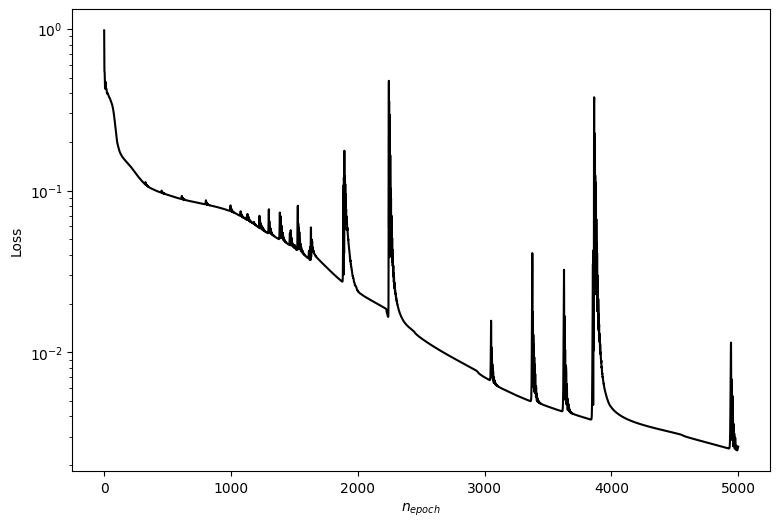

In [39]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.semilogy(range(len(historico)), historico,'k-')
ax.set_xlabel('$n_{epoch}$')
ax.set_ylabel('Loss');
plt.show()

In [40]:
t_dados = dados['t'].flatten()[:,None]
X_dados, T_dados = np.meshgrid(x_dados, t_dados)
X_comp = np.hstack((T_dados.flatten()[:,None], X_dados.flatten()[:,None]))
u_comp = u_dados.flatten()[:, None]

u_pred = modelo(X_comp)
erro_u = np.linalg.norm(u_comp-u_pred,2)/np.linalg.norm(u_comp,2)

In [41]:
print('Erro u: %e' % (erro_u))

Erro u: 6.613561e-02


In [42]:
class PINN_Arquitetura(keras.Model):

    def __init__(self, lb, ub,
            saida=1,
            camadas_ocultas=8,
            nos_ocultos=20,
            activation='tanh',
            kernel_initializer='glorot_normal',
            **kwargs):
        super().__init__(**kwargs)

        self.camadas_ocultas = camadas_ocultas
        self.saida = saida
        self.lb = lb
        self.ub = ub


        self.scale = keras.layers.Lambda(
            lambda x: 2.0*(x - lb)/(ub - lb) - 1.0)
        self.hidden = [Dense(nos_ocultos,
                             activation=keras.activations.get(activation),
                             kernel_initializer=kernel_initializer)
                           for _ in range(self.camadas_ocultas)]
        self.out = Dense(saida)

    def call(self, X):

        Z = self.scale(X)
        for i in range(self.camadas_ocultas):
            Z = self.hidden[i](Z)
        return self.out(Z)


In [51]:
class PINN():
    def __init__(self, modelo, X_r):
        self.modelo = modelo

        # Store collocation points
        self.t = X_r[:,0:1]
        self.x = X_r[:,1:2]

        # Initialize history of losses and global iteration counter
        self.hist = []
        self.iter = 0

    def get_r(self):

        with tf.GradientTape(persistent=True) as tape:
            # Watch variables representing t and x during this GradientTape
            tape.watch(self.t)
            tape.watch(self.x)

            # Compute current values u(t,x)
            u = self.modelo(tf.stack([self.t[:,0], self.x[:,0]], axis=1))

            u_x = tape.gradient(u, self.x)

        u_t = tape.gradient(u, self.t)
        u_xx = tape.gradient(u_x, self.x)

        del tape

        return self.fun_r(self.t, self.x, u, u_t, u_x, u_xx)

    def loss_fn(self, X, u):

        # Compute phi_r
        r = self.get_r()
        phi_r = tf.reduce_mean(tf.square(r))

        # Initialize loss
        loss = phi_r

        # Add phi_0 and phi_b to the loss
        for i in range(len(X)):
            u_pred = self.modelo(X[i])
            loss += tf.reduce_mean(tf.square(u[i] - u_pred))

        return loss

    def get_grad(self, X, u):
        with tf.GradientTape(persistent=True) as tape:
            # This tape is for derivatives with
            # respect to trainable variables
            tape.watch(self.modelo.trainable_variables)
            loss = self.loss_fn(X, u)

        g = tape.gradient(loss, self.modelo.trainable_variables)
        del tape

        return loss, g

    def fun_r(self, t, x, u, u_t, u_x, u_xx):
        """Residual of the PDE"""
        return u_t + u * u_x - mi * u_xx

    def solve_with_TFoptimizer(self, optimizer, X, u, N=1001):
        """This method performs a gradient descent type optimization."""

        @tf.function
        def train_step():
            loss, grad_theta = self.get_grad(X, u)

            # Perform gradient descent step
            optimizer.apply_gradients(zip(grad_theta, self.modelo.trainable_variables))
            return loss

        for i in range(N):

            loss = train_step()

            self.current_loss = loss.numpy()
            self.callback()

    def solve_with_ScipyOptimizer(self, X, u, method='L-BFGS-B', **kwargs):
        """This method provides an interface to solve the learning problem
        using a routine from scipy.optimize.minimize.
        (Tensorflow 1.xx had an interface implemented, which is not longer
        supported in Tensorflow 2.xx.)
        Type conversion is necessary since scipy-routines are written in Fortran
        which requires 64-bit floats instead of 32-bit floats."""

        def get_weight_tensor():
            """Function to return current variables of the modelo
            as 1d tensor as well as corresponding shapes as lists."""

            weight_list = []
            shape_list = []

            # Loop over all variables, i.e. weight matrices, bias vectors and unknown parameters
            for v in self.modelo.variables:
                shape_list.append(v.shape)
                weight_list.extend(v.numpy().flatten())

            weight_list = tf.convert_to_tensor(weight_list)
            return weight_list, shape_list

        x0, shape_list = get_weight_tensor()

        def set_weight_tensor(weight_list):
            """Function which sets list of weights
            to variables in the modelo."""
            idx = 0
            for v in self.modelo.variables:
                vs = v.shape

                # Weight matrices
                if len(vs) == 2:
                    sw = vs[0]*vs[1]
                    new_val = tf.reshape(weight_list[idx:idx+sw],(vs[0],vs[1]))
                    idx += sw

                # Bias vectors
                elif len(vs) == 1:
                    new_val = weight_list[idx:idx+vs[0]]
                    idx += vs[0]

                # Variables (in case of parameter identification setting)
                elif len(vs) == 0:
                    new_val = weight_list[idx]
                    idx += 1

                # Assign variables (Casting necessary since scipy requires float64 type)
                v.assign(tf.cast(new_val, 'float32'))

        def get_loss_and_grad(w):
            """Function that provides current loss and gradient
            w.r.t the trainable variables as vector. This is mandatory
            for the LBFGS minimizer from scipy."""

            # Update weights in modelo
            set_weight_tensor(w)
            # Determine value of \phi and gradient w.r.t. \theta at w
            loss, grad = self.get_grad(X, u)

            # Store current loss for callback function
            loss = loss.numpy().astype(np.float64)
            self.current_loss = loss

            # Flatten gradient
            grad_flat = []
            for g in grad:
                grad_flat.extend(g.numpy().flatten())

            # Gradient list to array
            grad_flat = np.array(grad_flat,dtype=np.float64)

            # Return value and gradient of \phi as tuple
            return loss, grad_flat


        return scipy.optimize.minimize(fun=get_loss_and_grad,
                                       x0=x0,
                                       jac=True,
                                       method=method,
                                       callback=self.callback,
                                       **kwargs)

    def callback(self, xr=None):
        if self.iter % 50 == 0:
            print('It {:05d}: loss = {:10.8e}'.format(self.iter,self.current_loss))
        self.hist.append(self.current_loss)
        self.iter+=1


    def plot_solution(self, **kwargs):
        N = 600
        tspace = np.linspace(self.modelo.lb[0], self.modelo.ub[0], N+1)
        xspace = np.linspace(self.modelo.lb[1], self.modelo.ub[1], N+1)
        T, X = np.meshgrid(tspace, xspace)
        Xgrid = np.vstack([T.flatten(),X.flatten()]).T
        upred = self.modelo(tf.cast(Xgrid,'float32'))
        U = upred.numpy().reshape(N+1,N+1)
        fig = plt.figure(figsize=(9,6))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(T, X, U, cmap='viridis', **kwargs)
        ax.set_xlabel('$t$')
        ax.set_ylabel('$x$')
        ax.set_zlabel('$u_\\theta(t,x)$')
        ax.view_init(35,35)
        return ax

    def plot_loss_history(self, ax=None):
        if not ax:
            fig = plt.figure(figsize=(7,5))
            ax = fig.add_subplot(111)
        ax.semilogy(range(len(self.hist)), self.hist,'k-')
        ax.set_xlabel('$n_{epoch}$')
        ax.set_ylabel('$\\phi^{n_{epoch}}$')
        return ax

In [53]:
modelo = PINN_Arquitetura(lb, ub)
modelo.build(input_shape=(None,2))

modelo_pinn = PINN(modelo, xr)

# Decide which optimizer should be used
#mode = 'TFoptimizer'
mode = 'ScipyOptimizer'

# Start timer
t0 = time()

if mode == 'TFoptimizer':
    # Choose optimizer
    lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000],[1e-2,1e-3,5e-4])
    optim = tf.keras.optimizers.Adam(learning_rate=lr)
    modelo_pinn.solve_with_TFoptimizer(optim, X_cond, u_cond, N=4001)

elif mode == 'ScipyOptimizer':
    modelo_pinn.solve_with_ScipyOptimizer(X_cond, u_cond,
                            method='L-BFGS-B',
                            options={'maxiter': 50000,
                                     'maxfun': 50000,
                                     'maxcor': 50,
                                     'maxls': 50,
                                     'ftol': 1.0*np.finfo(float).eps})

# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

It 03000: loss = 1.04795781e-05
It 03050: loss = 1.00022053e-05
It 03100: loss = 9.59977751e-06
It 03150: loss = 9.35169101e-06
It 03200: loss = 9.05382967e-06
It 03250: loss = 8.72153214e-06
It 03300: loss = 8.27381245e-06
It 03350: loss = 7.80861410e-06
It 03400: loss = 7.58790429e-06
It 03450: loss = 7.16594786e-06
It 03500: loss = 6.91879222e-06
It 03550: loss = 6.71780799e-06
It 03600: loss = 6.55097074e-06
It 03650: loss = 6.41856377e-06
It 03700: loss = 6.28912812e-06
It 03750: loss = 6.09373865e-06
It 03800: loss = 5.92921742e-06
It 03850: loss = 5.80075312e-06
It 03900: loss = 5.63797994e-06
It 03950: loss = 5.46895672e-06
It 04000: loss = 5.31612886e-06

Computation time: 1373.9159910678864 seconds
It 00000: loss = 4.52569962e-01
It 00050: loss = 1.07530706e-01
It 00100: loss = 7.40712062e-02
It 00150: loss = 5.05943038e-02
It 00200: loss = 2.86300499e-02
It 00250: loss = 1.53820543e-02
It 00300: loss = 7.45209539e-03
It 00350: loss = 3.59611632e-03
It 00400: loss = 2.4055333

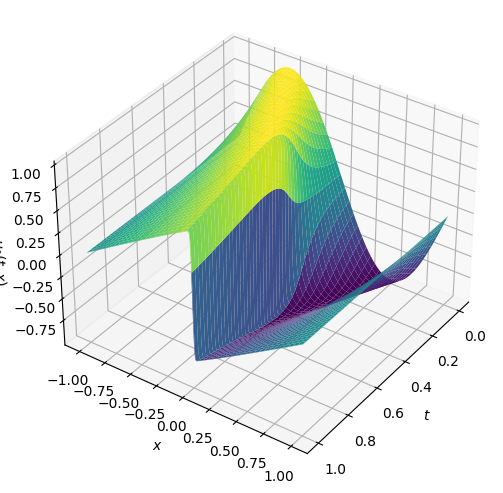

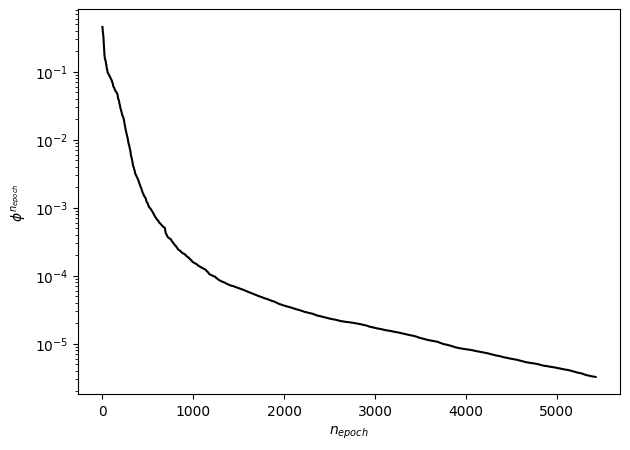

In [54]:
modelo_pinn.plot_solution();
modelo_pinn.plot_loss_history();